#### Classification | Model

# Predicting Heart Disease  

## Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exporatory Data Analysis](#3)<br/>
    Summarize<br/>
    Classification Viability<br/>
    Classification Metrics<br/>
4. [Baselining](#4)<br/>
5. [Validation](#5)<br/>
6. [Model Iterations](#6) <br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    model 1<br/>
    [Feature Engineering](#68)<br/>
    Class Imbalance<br/>
7. [Model Selection ](#7)<br/>



In [570]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import dataframe_image as dfi

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) 
sns.set_style("whitegrid")

from imblearn.under_sampling import RandomUnderSampler
# from ipywidgets import interactive, FloatSlider
from mlxtend.classifier import StackingClassifier 
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC ,SVR
from sklearn.tree import DecisionTreeClassifier




## 1 | Research Design<a id='1'></a> 

* **Reserach Question:** How might we predict which patients are at high risk of heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>
_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

[back to top](#top)

## 2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


In [3]:
# load clean and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('heart_disease_df.csv')
heart_disease_df_map = pd.read_csv('heart_disease_df_map.csv') 


In [ ]:
# clean df
heart_disease_df.head(3)


In [4]:
# transformed df: mapped categorical variables to numerical values 
heart_disease_df_map.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0


[back to top](#top)

## 3 | Exporatory Data Analysis<a id='3'></a> 

#### Using `heart_disease_df_map` with mapped variables for modeling.
##### Note: Full EDA part of [MVP](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).

### 3.1 Summarize data<a id='31'></a> 

In [ ]:
# dataframe info
heart_disease_df_map.info()


#### No missing data, all data types are numerical.

[back to top](#top)

### 3.2 Classification viability<a id='32'></a> 

In [ ]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')


In [5]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
behavior_activity,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283,-0.100030
behavior_alcohol,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254,-0.032080
behavior_sleep,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387,0.008327
behavior_tobacco,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352,0.107764
demg_age,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789,0.232325
demg_gender,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904,0.070040
demg_race,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847,0.034854
disease_asthma,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907,0.041444
disease_diabetes,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644,0.118281
disease_kidney,-0.081827,-0.028280,0.006238,0.034920,0.122697,-0.009084,0.003709,0.039707,0.095186,1.000000,0.061816,0.091167,0.050768,-0.174642,0.037281,0.153064,0.142197,0.145197


#### A classification model is viable.

[back to top](#top)

In [ ]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


[back to top](#top)

### 3.3 Classification metrics<a id='33'></a> 

In [612]:
# Classification Metrics Summary (X/y_val)

base = ["Baseline logistic regression",
        recall_score(log_reg_base.predict(X_val_scaled_base), y_val_base),
        roc_auc_score(y_val_base, log_reg_base.predict_proba(X_val_scaled_base)[:,1])]

dummy = ["Dummy classifier",  
         recall_score(clf.predict(X_val), y_val), 
         roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])]

one = ["Logistic regression",
       recall_score(log_reg.predict(X_val_scaled), y_val), 
       roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])]
         
two = ["Decision tree (depth=2)",  
       recall_score(dt_2.predict(X_val), y_val), 
       roc_auc_score(y_val, dt_2.predict_proba(X_val_scaled)[:,1])]
three = ["Decision tree (depth=4)",
         recall_score(dt_4.predict(X_val), y_val),
         roc_auc_score(y_val, dt_4.predict_proba(X_val_scaled)[:,1])]
four = ["Random forest",
        recall_score(forest.predict(X_val), y_val),
        roc_auc_score(y_val, forest.predict_proba(X_val_scaled)[:,1])]
five = ["XGBoost", 
        recall_score(y_val, np.round(gbm.predict(X_val))), 
        roc_auc_score(y_val, np.round(gbm.predict(X_val)))]
six = ["Bernoulli NB", 
       recall_score(bern.predict(X_val), y_val),
       roc_auc_score(y_val, np.round(bern.predict(X_val), 4))]
seven = ["Gaussian NB",
         recall_score(gaus.predict(X_val), y_val),
         roc_auc_score(y_val, np.round(gaus.predict(X_val)))]
eight = ["Multinomial NB",
         recall_score(multi.predict(X_val), y_val),
         roc_auc_score(y_val, np.round(multi.predict(X_val)))]
nine = ["Hard NB Voting Classifier",
        recall_score(vote_hard.predict(X_val), y_val), 
        roc_auc_score(y_val, (vote_hard.predict(X_val)))]
ten = ["Soft NB Voting Classifier", 
       recall_score(vote_soft.predict(X_val), y_val), 
       roc_auc_score(y_val, (vote_soft.predict(X_val)))]
eleven = ["Stacked", 
#           recall_score(y_test, y_pred_stack),
#           accuracy_score(y_test, y_pred_stack)
         ]
tweleve = ["Logistic regression group features", 
           recall_score(log_reg_grp.predict(X_val_grp_scaled), y_val_grp), 
           roc_auc_score(y_val_grp, log_reg_grp.predict_proba(X_val_grp_scaled)[:,1])]
thriteen = ["Logistic regression risk factor features", 
            recall_score(log_reg_risk.predict(X_val_risk_scaled), y_val_risk), 
            roc_auc_score(y_val_risk, log_reg_risk.predict_proba(X_val_risk_scaled)[:,1])]
fourteen = ["Logistic regression question groups + risk factor features", 
            recall_score(log_reg_grp_risk.predict(X_val_grp_risk_scaled), y_val_grp_risk), 
            roc_auc_score(y_val_grp_risk, log_reg_grp_risk.predict_proba(X_val_grp_risk_scaled)[:,1])]
fifteen = ['Logistic regression GridSearchCV', 
             recall_score(log_reg_best.predict(X_val_scaled), y_val),
             roc_auc_score(y_val, log_reg_best.predict_proba(X_val_scaled)[:,1])]


data = base, dummy, zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thriteen, fourteen, fifteen
model_eval = pd.DataFrame(data = data, columns = ['Model', 'Recall', 'ROC AUC'])
model_eval

,Model,Recall,ROC AUC
0,Baseline logistic regression,0.360000,0.785826
1,Dummy classifier,0.000000,0.500000
2,Baseline logistic regression,0.360000,0.785826
3,Logistic regression,0.519505,0.841142
4,Decision tree (depth=2),0.000000,0.500000
5,Decision tree (depth=4),0.000000,0.568281
6,Random forest,0.371656,0.640793
7,XGBoost,0.084943,0.539077
8,Bernoulli NB,0.365447,0.595214
9,Gaussian NB,0.264537,0.674079


* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients. 

[back to top](#top)

## 4 | Baseline<a id='4'></a> 

#### Logistic regression with three features based on correlation matrix.

In [6]:
# separate target from features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease'] 
X_base = heart_disease_df_map.loc[:, [
#     'behavior_activity', 
#     'behavior_alcohol', 
#     'behavior_sleep',
#     'behavior_tobacco',
    'demg_age',
#     'demg_gender', 
#     'demg_race',
#     'disease_asthma', 
#     'disease_diabetes', 
#     'disease_kidney', 
#     'disease_skin', 
#     'disease_stroke', 
#     'health_bmi', 
#     'health_general', 
#     'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split baseline data test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,
                                                                        y_base,
                                                                        test_size=0.2,
                                                                        random_state=42)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base, 
                                                                                y_train_base, 
                                                                                test_size = .25, 
                                                                                random_state = 42)

# scale baseline X train/test
scaler = StandardScaler()
X_train_scaled_base = scaler.fit_transform(X_train_base)
X_test_scaled_base = scaler.transform(X_test_base)
X_val_scaled_base = scaler.transform(X_val_base)


In [613]:
# baseline logistic regression X train scaled & y train
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m 
y_pred_base = log_reg_base.predict(X_val_scaled_base) 


# score on X_test_scaled and y_test
model_eval[0:1]


,Model,Recall,ROC AUC
0,Baseline logistic regression,0.36,0.785826


[back to top](#top)

## 5 | Validation<a id='5'></a>

#### Validation and testing scheme to use in [model selection](#7). 

In [10]:
# separate target from features 
y = heart_disease_df_map['y_heart_disease'] 
X = heart_disease_df_map.loc[:, [
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split data test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size = .25, 
                                                            random_state = 42)

# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


[back to top](#top)

## 6 | Model Iterations <a id='6'></a> 

### 6.1 Dummy Classifier<a id='61'></a> 

In [615]:
clf = DummyClassifier(strategy= 'most_frequent')
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_val)

model_eval[1:2]

,Model,Recall,ROC AUC
1,Dummy classifier,0.0,0.5


[back to top](#top)

### 6.2 Logistic Regression<a id='62'></a> 

In [618]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled) 

model_eval[2:3]


,Model,Recall,ROC AUC
2,Baseline logistic regression,0.36,0.785826


#### Logistic regression with all features improved on recall and ROC AUC score improved from [baseline](#4).<br/>

[back to top](#top)

### 6.3 Decision Trees<a id='63'></a> 

In [382]:
# tree max depth 2
dt_2 = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_2.fit(X_train, y_train)
y_pred = dt_2.predict(X_val)

model_eval[2:3]


,Model,Recall,ROC AUC
2,Decision tree (depth=2),0.0,0.5


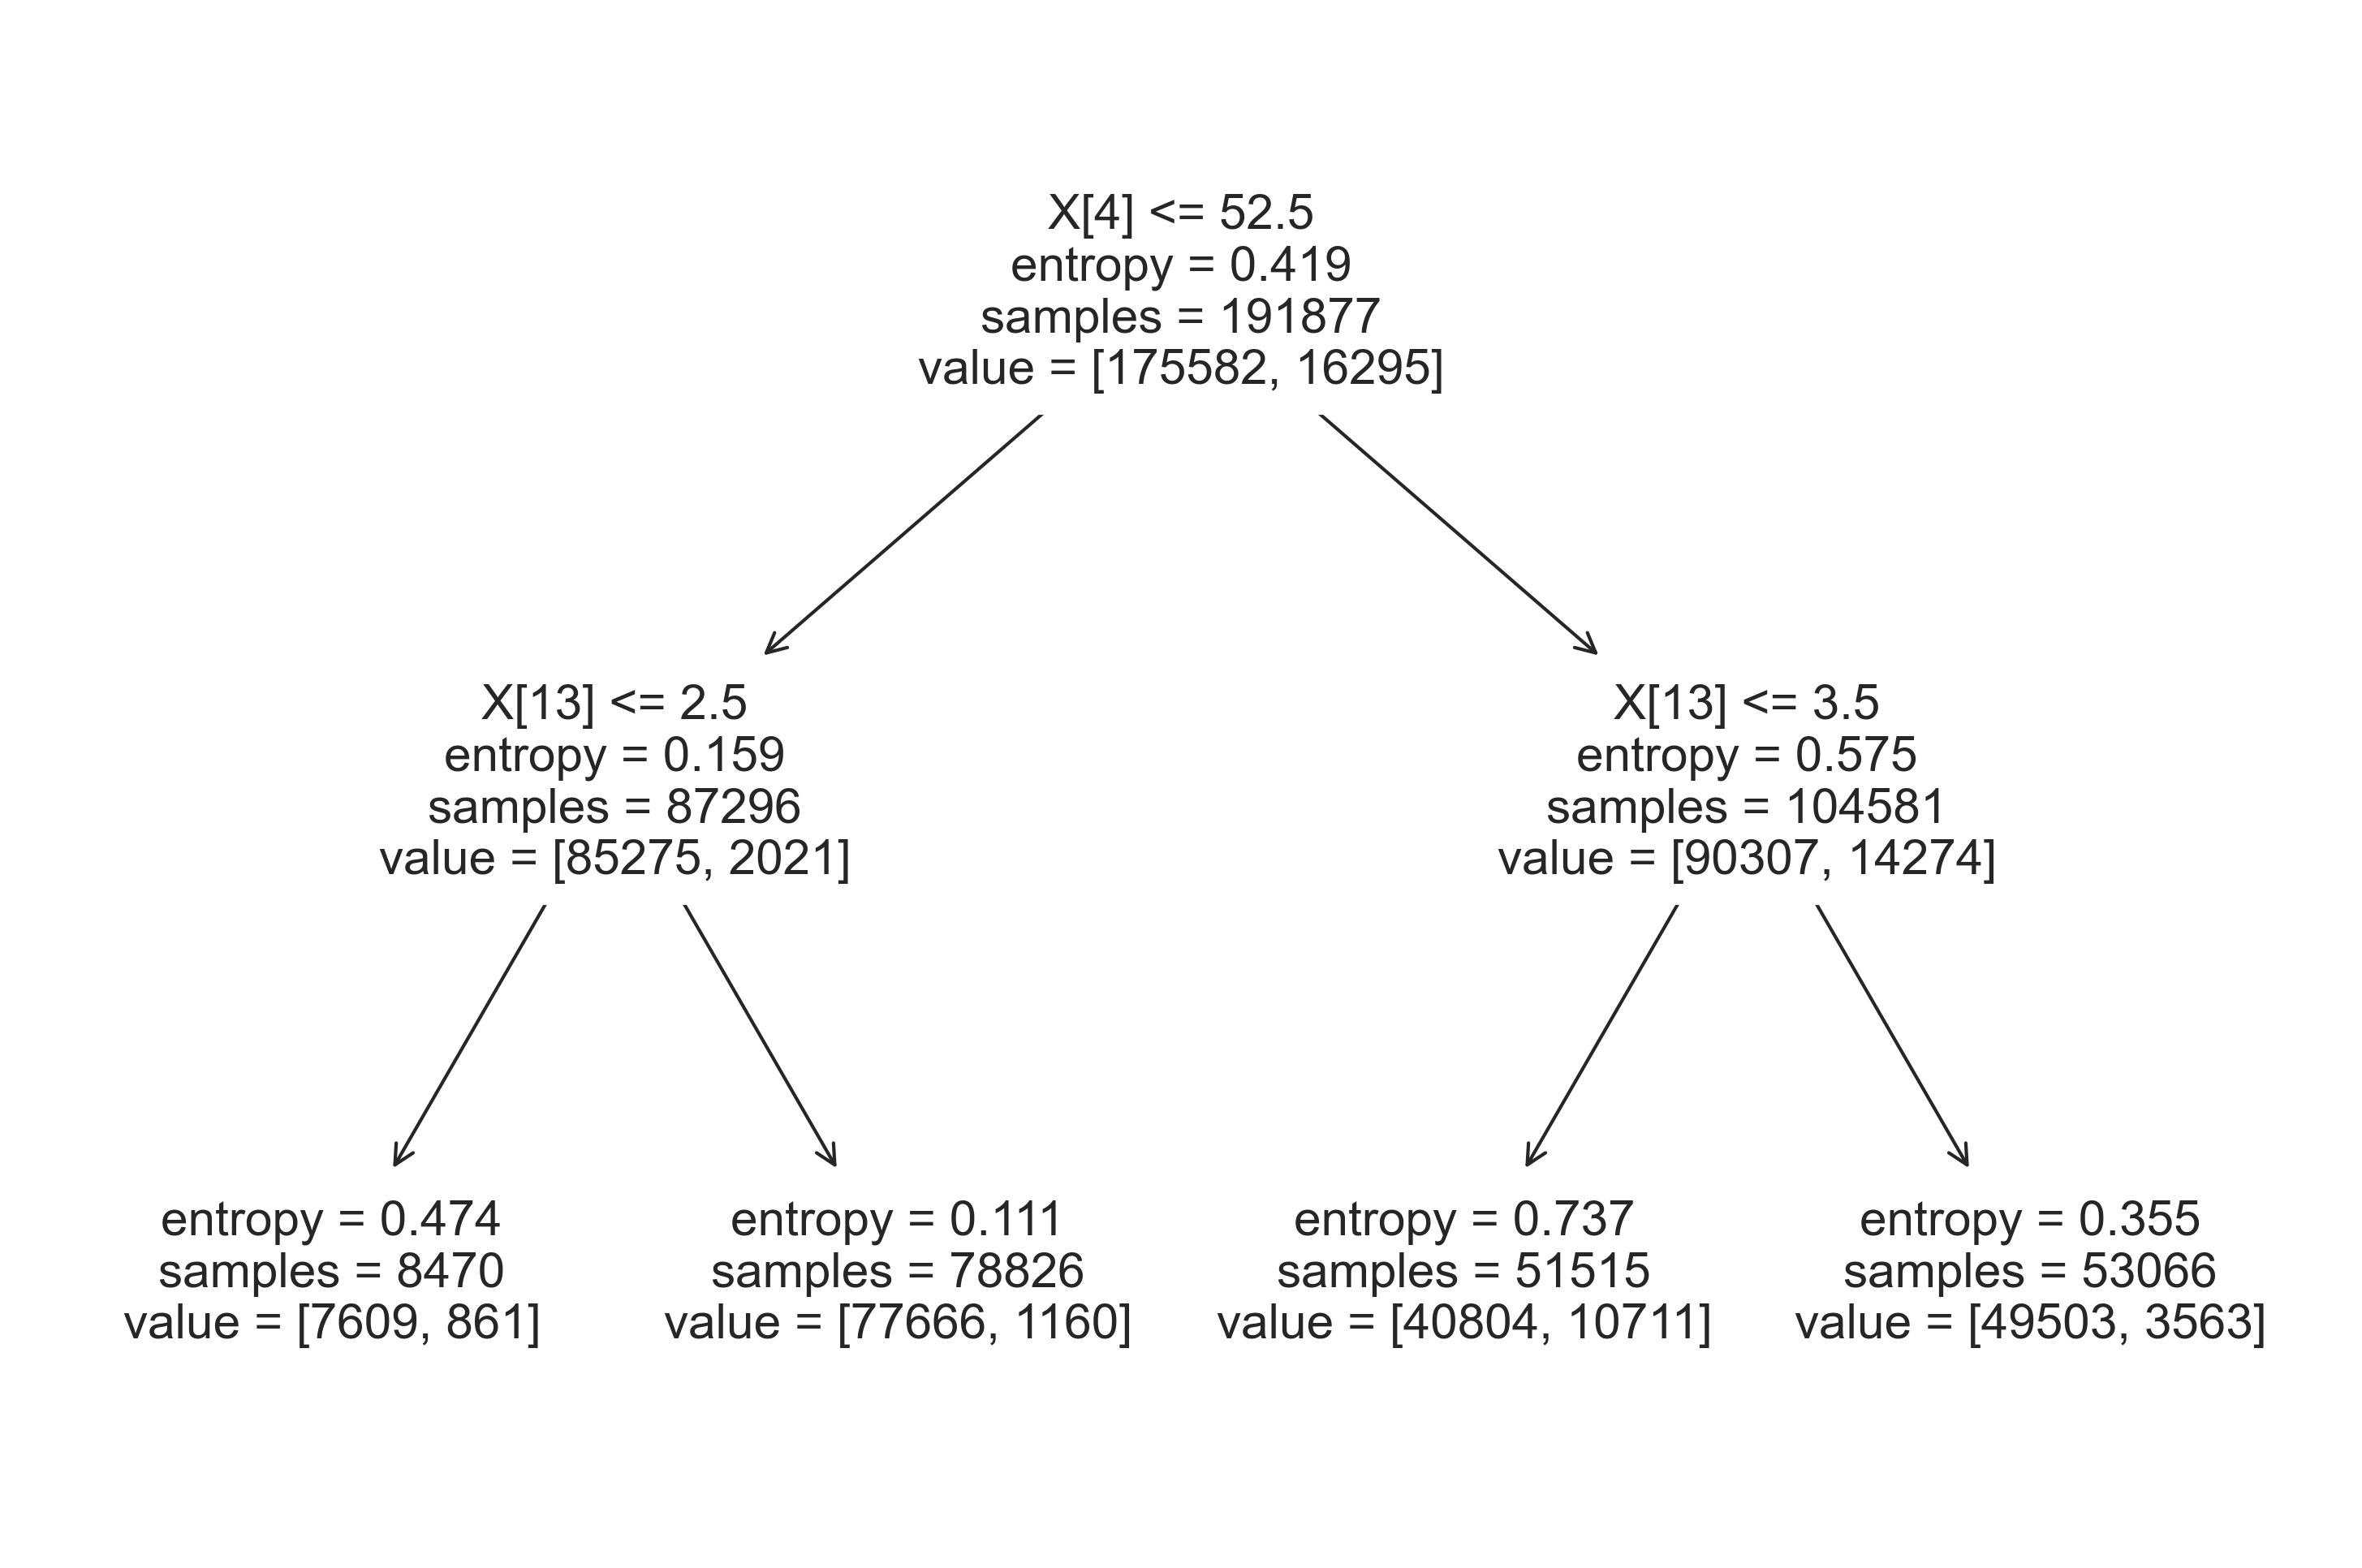

In [352]:
tree.plot_tree(dt_2);

In [383]:
# tree max depth 4
dt_4 = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt_4.fit(X_train, y_train)
y_pred = dt_4.predict(X_val)

model_eval[3:4]

,Model,Recall,ROC AUC
3,Decision tree (depth=4),0.0,0.568281


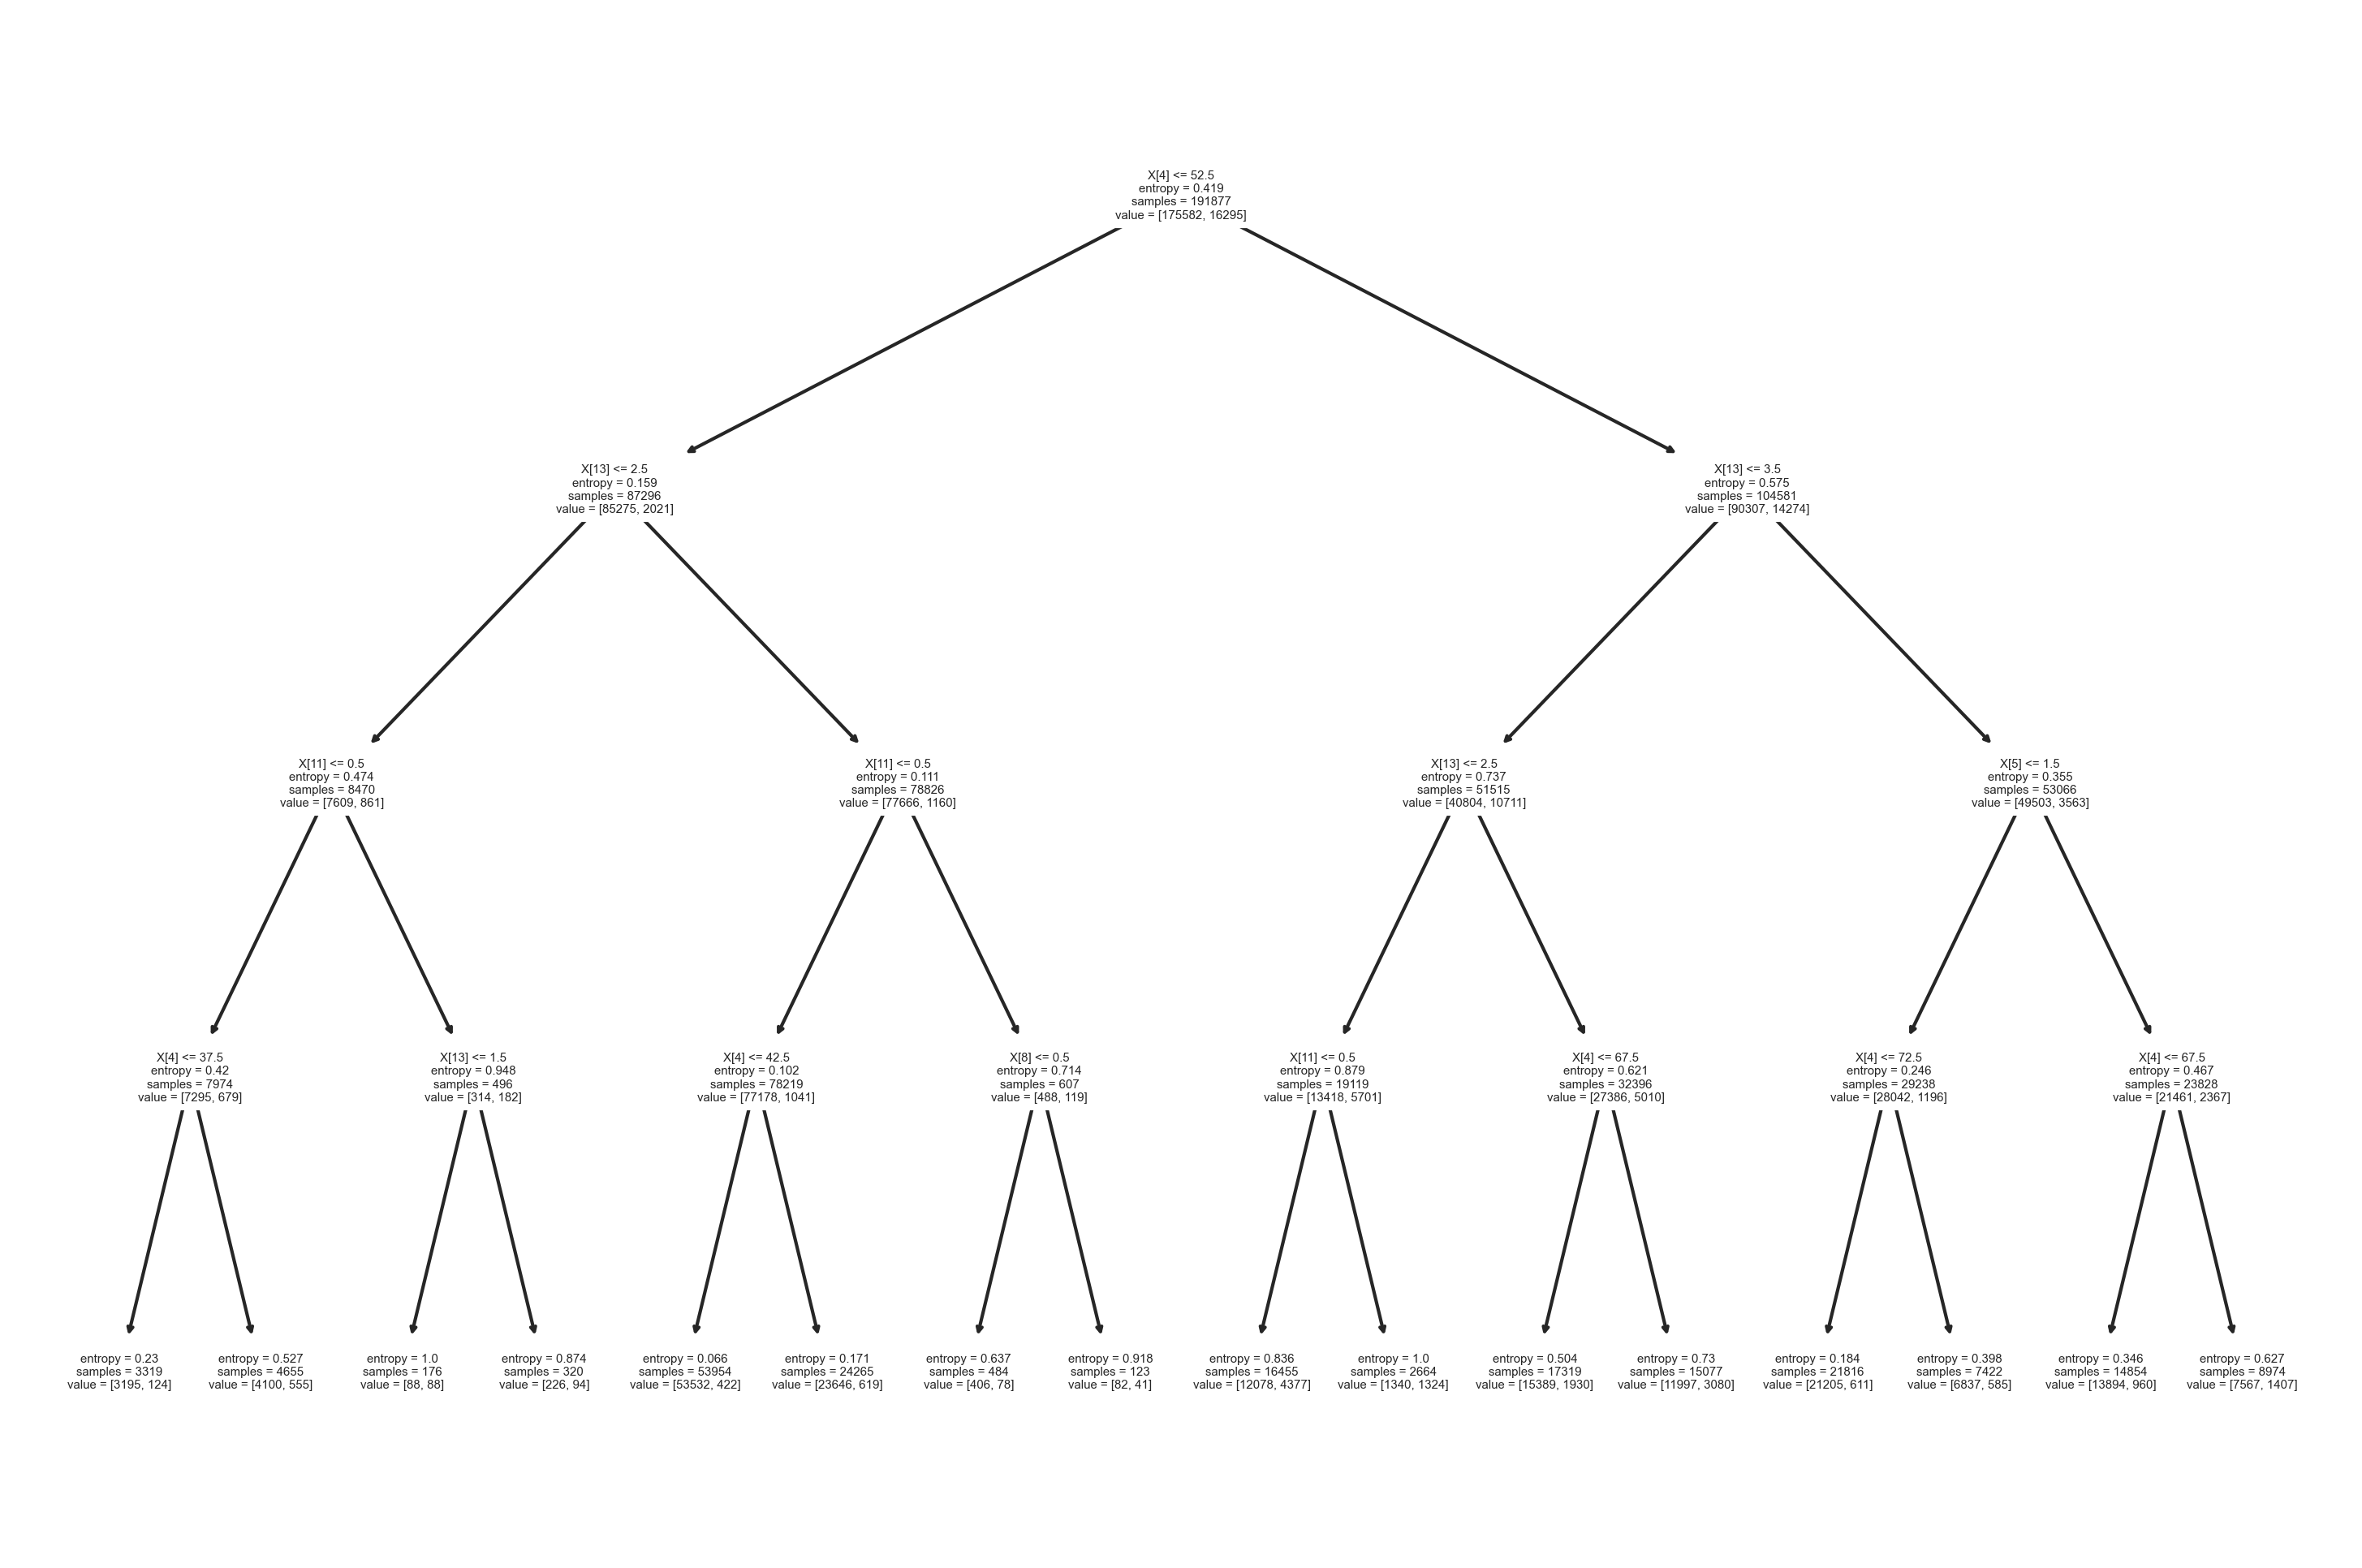

In [389]:
tree.plot_tree(dt_4);

#### Decsion trees perform worse than [logistic regression](#62). 

### 6.4 Random Forests <a id='64'></a> 

In [388]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = forest.predict(X_val)

# model_eval[4:5]

#### Random forest model performs worse than [logistic regression](#62). 

[back to top](#top)

### 6.5 Gradient Boosted Trees: xgboost<a id='65'></a> 

In [229]:
# XGBoost

gbm = xgb.XGBRegressor( 
                    n_estimators=30000,
                    max_depth=3,
                    objective="binary:logistic",
                    eval_metric='auc',
                    learning_rate=.1,
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8
                    )

eval_set=[(X_train, y_train),(X_val,y_val)] 

gbm_fit = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
#                     eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True 
                   )

[0]	validation_0-auc:0.79108	validation_1-auc:0.79024
[1]	validation_0-auc:0.80688	validation_1-auc:0.80559
[2]	validation_0-auc:0.81821	validation_1-auc:0.81637
[3]	validation_0-auc:0.81953	validation_1-auc:0.82055
[4]	validation_0-auc:0.82335	validation_1-auc:0.82405
[5]	validation_0-auc:0.82174	validation_1-auc:0.82318
[6]	validation_0-auc:0.82506	validation_1-auc:0.82588
[7]	validation_0-auc:0.82664	validation_1-auc:0.82673
[8]	validation_0-auc:0.82789	validation_1-auc:0.82793
[9]	validation_0-auc:0.82791	validation_1-auc:0.82748
[10]	validation_0-auc:0.82808	validation_1-auc:0.82850
[11]	validation_0-auc:0.82813	validation_1-auc:0.82799
[12]	validation_0-auc:0.82846	validation_1-auc:0.82820
[13]	validation_0-auc:0.82927	validation_1-auc:0.82856
[14]	validation_0-auc:0.82918	validation_1-auc:0.82809
[15]	validation_0-auc:0.83040	validation_1-auc:0.82932
[16]	validation_0-auc:0.83116	validation_1-auc:0.83017
[17]	validation_0-auc:0.83138	validation_1-auc:0.83071
[18]	validation_0-au

[149]	validation_0-auc:0.84723	validation_1-auc:0.84445
[150]	validation_0-auc:0.84725	validation_1-auc:0.84445
[151]	validation_0-auc:0.84726	validation_1-auc:0.84445
[152]	validation_0-auc:0.84727	validation_1-auc:0.84444
[153]	validation_0-auc:0.84730	validation_1-auc:0.84447
[154]	validation_0-auc:0.84732	validation_1-auc:0.84446
[155]	validation_0-auc:0.84734	validation_1-auc:0.84447
[156]	validation_0-auc:0.84737	validation_1-auc:0.84446
[157]	validation_0-auc:0.84740	validation_1-auc:0.84448
[158]	validation_0-auc:0.84741	validation_1-auc:0.84447
[159]	validation_0-auc:0.84743	validation_1-auc:0.84447
[160]	validation_0-auc:0.84747	validation_1-auc:0.84447
[161]	validation_0-auc:0.84747	validation_1-auc:0.84447
[162]	validation_0-auc:0.84748	validation_1-auc:0.84447
[163]	validation_0-auc:0.84750	validation_1-auc:0.84447
[164]	validation_0-auc:0.84752	validation_1-auc:0.84446
[165]	validation_0-auc:0.84754	validation_1-auc:0.84447
[166]	validation_0-auc:0.84755	validation_1-auc:

#### [220]	validation_0-auc: 0.84848	validation_1-auc: 0.84449


In [158]:
y_pred_gbm = gbm.predict(X_val)
y_pred_gbm

array([0.00727439, 0.02875089, 0.1310833 , ..., 0.00484608, 0.12610735,
       0.00575493], dtype=float32)

In [390]:
model_eval[5:6]

,Model,Recall,ROC AUC
5,XGBoost,0.084943,0.539077


#### XGBoost model performs worse than [logistic regression](#62). 

[back to top](#top)

### 6.6. Naive Bayes<a id='67'></a> 

In [360]:
# BernoulliNB() 
bern = BernoulliNB().fit(X_train, y_train)
y_predict_bern = bern.predict(X_val) 

model_eval[6:7]

,Model,Recall,ROC AUC
6,Bernoulli NB,0.3654,0.595214


In [361]:
# GaussianNB()
gaus = GaussianNB().fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_val)

model_eval[7:8]

,Model,Recall,ROC AUC
7,Gaussian NB,0.2645,0.674079


In [362]:
# MultinomialNB()
multi = MultinomialNB().fit(X_train, y_train)
y_pred_multi = multi.predict(X_val)

model_eval[8:9]

,Model,Recall,ROC AUC
8,Multinomial NB,0.2188,0.611716


In [365]:
nb_names = ['bern', 'gaus', 'multi']
nb_vars = [eval(n) for n in nb_names]

nb_list = list(zip(nb_names, nb_vars))
nb_list


[('bern', BernoulliNB()), ('gaus', GaussianNB()), ('multi', MultinomialNB())]

#### Naive Bayes models perform worse than [logistic regression](#62). 

### 6.7 Ensemble<a id='67'></a> 

### A. Naive Bayes Voting Classifiers: Hard/Soft

In [367]:
# Hard NB voting classifier
vote_hard = VotingClassifier(estimators= nb_list,
                             voting='hard',
                             n_jobs=-1)

vote_hard.fit(X_train, y_train)

model_eval[9:10]


,Model,Recall,ROC AUC
9,Hard NB Voting Classifier,0.2934,0.633538


In [369]:
# Soft NB voting classifier 
vote_soft = VotingClassifier(estimators= nb_list,
                             voting='soft',
                             n_jobs=-1)

vote_soft.fit(X_train, y_train)

model_eval[10:11]


,Model,Recall,ROC AUC
10,Soft NB Voting Classifier,0.287,0.637002


#### Voting classifer ensemble of Naive Bayes models performs worse than [logistic regression](#62). 

### B. Stacking

In [237]:
model_names = ['knn', 'log_reg', 'dt_2', 'dt_4', 'forest', 'gbm']

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))
model_list

[('knn', KNeighborsClassifier(n_neighbors=3)),
 ('log_reg', LogisticRegression()),
 ('dt_2', DecisionTreeClassifier(criterion='entropy', max_depth=2)),
 ('dt_4', DecisionTreeClassifier(criterion='entropy', max_depth=4)),
 ('forest', RandomForestClassifier()),
 ('gbm',
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=30000,
               n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
               predictor='auto', random_state=0, reg_alpha=0, ...))]

In [238]:
stacked = StackingClassifier(
    classifiers= model_vars, 
    meta_classifier=LogisticRegression(), 
    use_probas=False)

In [241]:
stacked.fit(X_train, y_train)

In [392]:
# y_pred_stack = stacked.predict(X_test)

# model_eval[11:12]

# not running

#### Stacking ensemble of all but Naive Bayes models performs ??? than [logistic regression](#62). 


[back to top](#top)

### 6.8 Feature Engineering <a id='68'></a> 

### A. New features: question groups
Groups of similar survey question questions as defined by [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf).

In [244]:
# 1 behaviors = phyiscial activity days/month + sleep time hrs/day + alcohol + tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +  
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age + gender + race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +  
    heart_disease_df_map['demg_race'])

# 3 disease = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +  
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 (health) measures = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +  
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures'],
      dtype='object')

### B. New features: risk factors
Heart disease risk factors by [CDC](https://www.cdc.gov/heartdisease/facts.htm). 

In [246]:
# risk factors = diabetes + bmi + physical activity + alcohol
heart_disease_df_map['risk_factors'] = (
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['health_bmi'] +  
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures', 'risk_factors'],
      dtype='object')

### Logistic regression A: question groups<a id='68a'></a> 

In [250]:
# separate target from question groups features: y/X_f
y_grp = heart_disease_df_map['y_heart_disease'] 
X_grp = heart_disease_df_map.loc[:, ['behaviors', 
                                   'demographics', 
                                   'disease', 
                                   'measures']]

# split data test/train/validate
X_train_grp, X_test_grp, y_train_grp, y_test_grp = train_test_split(X_grp, 
                                                    y_grp, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_grp, X_val_grp, y_train_grp, y_val_grp = train_test_split(X_train_grp, 
                                                                    y_train_grp, 
                                                                    test_size = .25, 
                                                                    random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_scaled = scaler.fit_transform(X_train_grp)
X_test_grp_scaled = scaler.transform(X_test_grp)
X_val_grp_scaled = scaler.transform(X_val_grp)


In [595]:
# LR question groups features
log_reg_grp = LogisticRegression()
log_reg_grp.fit(X_train_grp_scaled, y_train_grp)
y_pred_grp = log_reg_grp.predict(X_val_grp_scaled) 

model_eval[12:13]


,Model,Recall,ROC AUC
12,Logistic regression group features,0.389535,0.797162


Logistic regression with only engineered features performs worse than first iteration of [logistic regression](#6b). 

### Logistic regression B: risk factors<a id='68b'></a>

In [253]:
# separate target from engineered features: y/X_rf
y_risk = heart_disease_df_map['y_heart_disease'] 
X_risk = heart_disease_df_map.loc[:, ['disease_diabetes',
                                    'health_bmi',
                                    'behavior_activity', 
                                   'behavior_alcohol']]

# split data test/train/validate
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, 
                                                    y_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_risk, X_val_risk, y_train_risk, y_val_risk = train_test_split(X_train_risk, 
                                                                        y_train_risk, 
                                                                        test_size = .25, 
                                                                        random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_risk_scaled = scaler.fit_transform(X_train_risk)
X_test_risk_scaled = scaler.transform(X_test_risk)
X_val_risk_scaled = scaler.transform(X_val_risk)


In [594]:
# LR risk factor features
log_reg_risk = LogisticRegression()
log_reg_risk.fit(X_train_risk_scaled, y_train_risk)
y_pred_risk = log_reg_risk.predict(X_val_risk_scaled) 

model_eval[13:14]


,Model,Recall,ROC AUC
13,Logistic regression risk factor features,0.0,0.645987


Logistic regression with risk factor features performs `better/worse` than [logistic regression ...](#6..) and `better/worse` than [logistic regression ...](#6..). 
    

[back to top](#top)

### Logistic regression AB: question groups + risk factors features<a id='68ab'></a> 

In [257]:
# separate target from question groups + risk factor features: y/X_new
y_grp_risk = heart_disease_df_map['y_heart_disease'] 
X_grp_risk = heart_disease_df_map.loc[:, [
    'behaviors', 
    'demographics', 
    'disease', 
    'measures',
    'behavior_activity',
    'behavior_alcohol',
    'disease_diabetes',
    'health_bmi'
    ]]

# split data test/train/validate
X_train_grp_risk, X_test_grp_risk, y_train_grp_risk, y_test_grp_risk = train_test_split(X_grp_risk, 
                                                    y_grp_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train_grp_risk, X_val_grp_risk, y_train_grp_risk, y_val_grp_risk = train_test_split(X_train_grp_risk, 
                                                                            y_train_grp_risk, 
                                                                            test_size = .25, 
                                                                            random_state = 42)

# Scale X train/test/validate
scaler = StandardScaler()
X_train_grp_risk_scaled = scaler.fit_transform(X_train_grp_risk)
X_test_grp_risk_scaled = scaler.transform(X_test_grp_risk)
X_val_grp_risk_scaled = scaler.transform(X_val_grp_risk)


In [596]:
# LR question groups + risk factor features
log_reg_grp_risk = LogisticRegression()
log_reg_grp_risk.fit(X_train_grp_risk_scaled, y_train_grp_risk)
y_pred_grp_risk = log_reg_grp_risk.predict(X_val_grp_risk_scaled) 

model_eval[14:15]


,Model,Recall,ROC AUC
14,Logistic regression question groups + risk fac...,0.466844,0.799779


#### Feature engineering models perform worse than [logistic regression](#62). 


[back to top](#top)

## Class Imblance Handling <a id='6g'></a> 

In [538]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

0    292422
1     27373
Name: y_heart_disease, dtype: int64

In [ ]:
# resample?

In [ ]:
# class_weight adjustments
# _sklearn fbeta score – f2 or f3 to upweight recall_

In [ ]:
# decision threshold to max recall

[back to top](#top)

## 7 | Model Selection<a id='7'></a> 

#### Model winner: 

#### [Logistic regression](#62) performs best on recall and ROC AUC. 


In [597]:
model_eval.sort_values(by='Recall', ascending=False).head(5)


,Model,Recall,ROC AUC
1,Logistic regression,0.519505,0.841142
14,Logistic regression question groups + risk fac...,0.466844,0.799779
12,Logistic regression group features,0.389535,0.797162
4,Random forest,0.371656,0.640793
6,Bernoulli NB,0.365447,0.595214


In [598]:
model_eval.sort_values(by='ROC AUC', ascending=False).head(5)


,Model,Recall,ROC AUC
1,Logistic regression,0.519505,0.841142
14,Logistic regression question groups + risk fac...,0.466844,0.799779
12,Logistic regression group features,0.389535,0.797162
0,Baseline logistic regression,0.360000,0.785826
7,Gaussian NB,0.264537,0.674079


In [568]:
#GridSearchCV to find best C and penalty

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_1 = LogisticRegression()
logreg_cv = GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.9158627651711446


In [584]:
# 
log_reg_best = LogisticRegression(C=0.01,penalty="l2")
log_reg_best.fit(X_train_scaled, y_train)
y_pred_log_reg_best = log_reg_best.predict(X_val_scaled) 

print('recall', recall_score(log_reg_best.predict(X_val_scaled), y_val))
print('roc auc', roc_auc_score(y_val, log_reg_best.predict_proba(X_val_scaled)[:,1]))

recall 0.5222437137330754
roc auc 0.8412275311651765


In [585]:
# # precision and recall curves

# precision_curve, recall_curve, threshold_curve = precision_recall_curve(
#     y_test, log_reg.predict_proba(X_test)[:,1] )

# f, ax = plt.subplots(figsize=(10, 6))
# plt.plot(threshold_curve, precision_curve[1:],label='precision')
# plt.plot(threshold_curve, recall_curve[1:], label='recall')
# plt.legend(loc='center')
# plt.xlabel('Threshold');
# plt.title('Precision and Recall Curves')
# plt.savefig("precision-recall-curves.jpeg");

### 7.1 Finalize and test<a id='71'></a> 

- When satisfied with the results of your tuning in _Model Iterations_, establish your final model choices:
        - features, 
        - preprocessing, 
        - imbalance handling strategy, and 
        - hyperparameters
    - retrain this model on all training + validation data. 
- Make predictions on the test data and score these predictions, reporting this score as your estimate of the model's generalization performance.


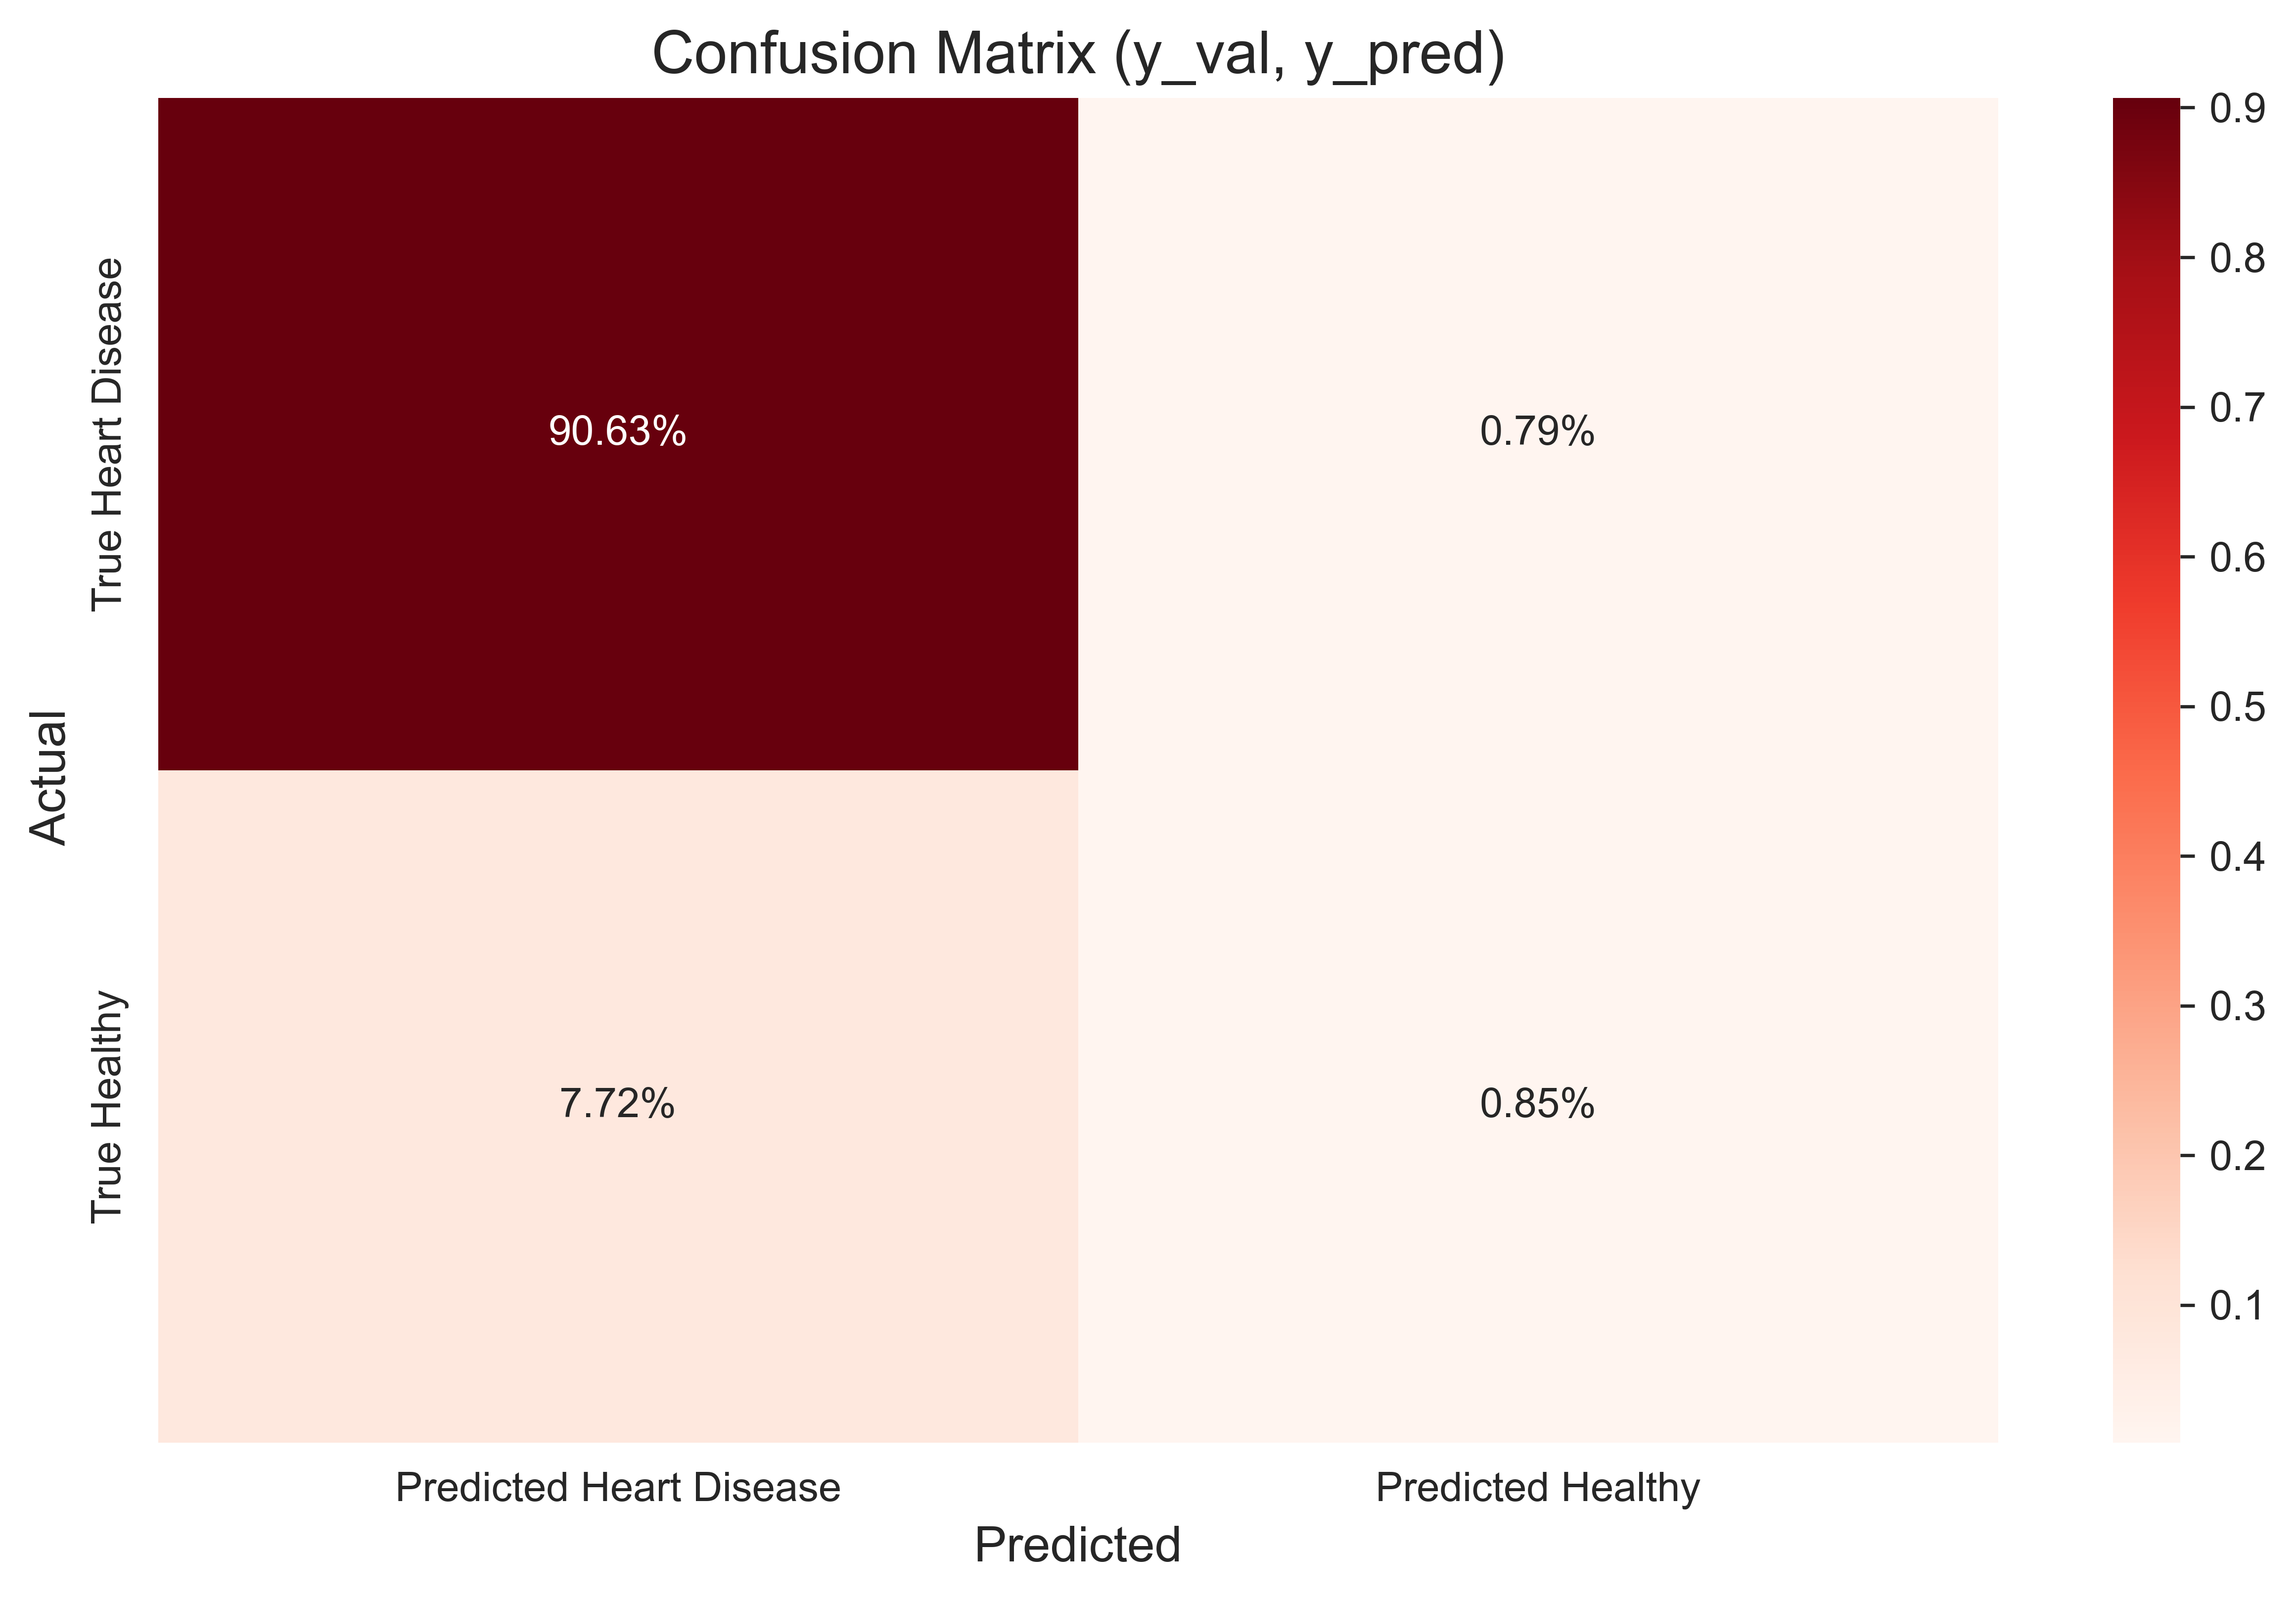

In [535]:
# Confusion matrix on y_validate, y_pred_log_reg
cm = confusion_matrix(y_val, y_pred_log_reg)

f, ax = plt.subplots(figsize=(10, 6))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')

ax.xaxis.set_ticklabels(['Predicted Heart Disease','Predicted Healthy'])            #double check x y labels
ax.yaxis.set_ticklabels(['True Heart Disease','True Healthy'])

plt.title('Confusion Matrix (y_val, y_pred)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual ')

plt.savefig("confusion-matrix.jpeg");


In [324]:
# classification report on y_validate/predict
print(classification_report(y_val, 
                            y_pred_log_reg, 
                            target_names=['no heart disease', 'yes heart disease']))



                   precision    recall  f1-score   support

 no heart disease       0.92      0.99      0.96     58473
yes heart disease       0.52      0.10      0.17      5486

         accuracy                           0.91     63959
        macro avg       0.72      0.55      0.56     63959
     weighted avg       0.89      0.91      0.89     63959



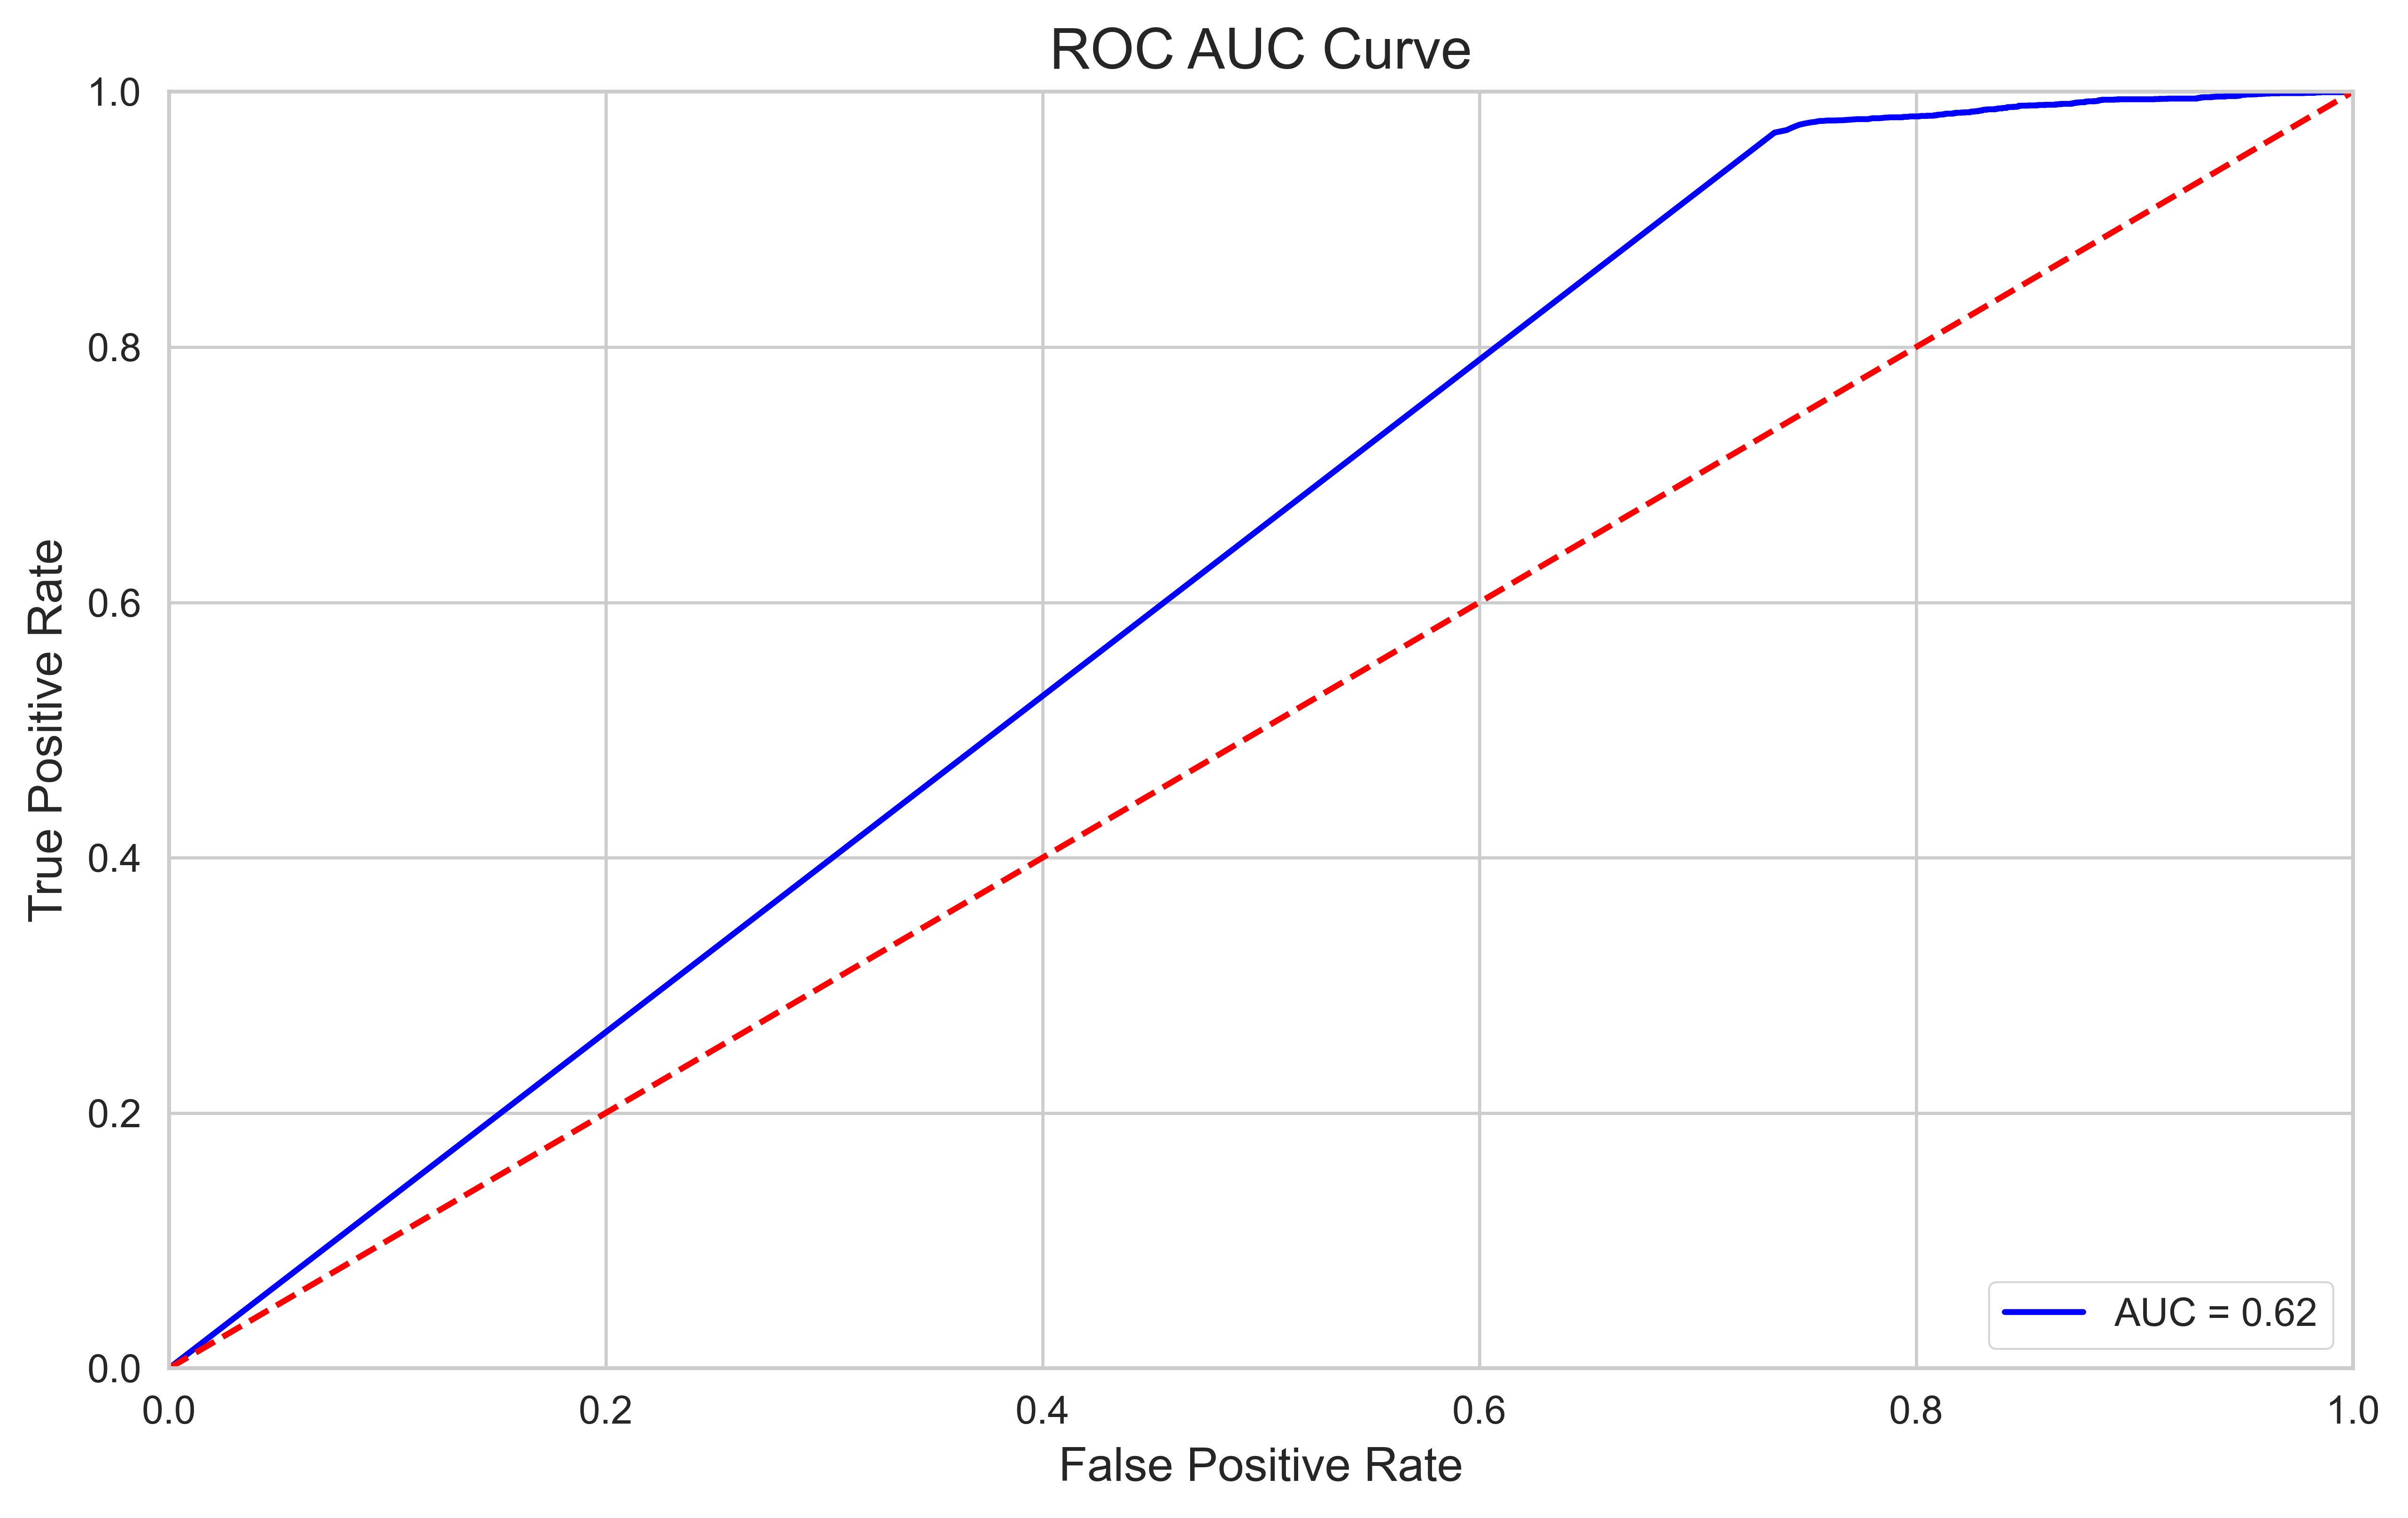

In [332]:
# ROC AUC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = log_reg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


f, ax = plt.subplots(figsize=(10, 6))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('ROC AUC Curve')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("roc-auc-curve.jpeg");

In [326]:
# feature importance
imp_feat = pd.DataFrame()
feat = list(X)
imp = log_reg.coef_[0]
imp_feat['Feature'] = feat
imp_feat['Importance'] = imp
imp_feat.sort_values(by=['Importance'], ascending=False, inplace=True)


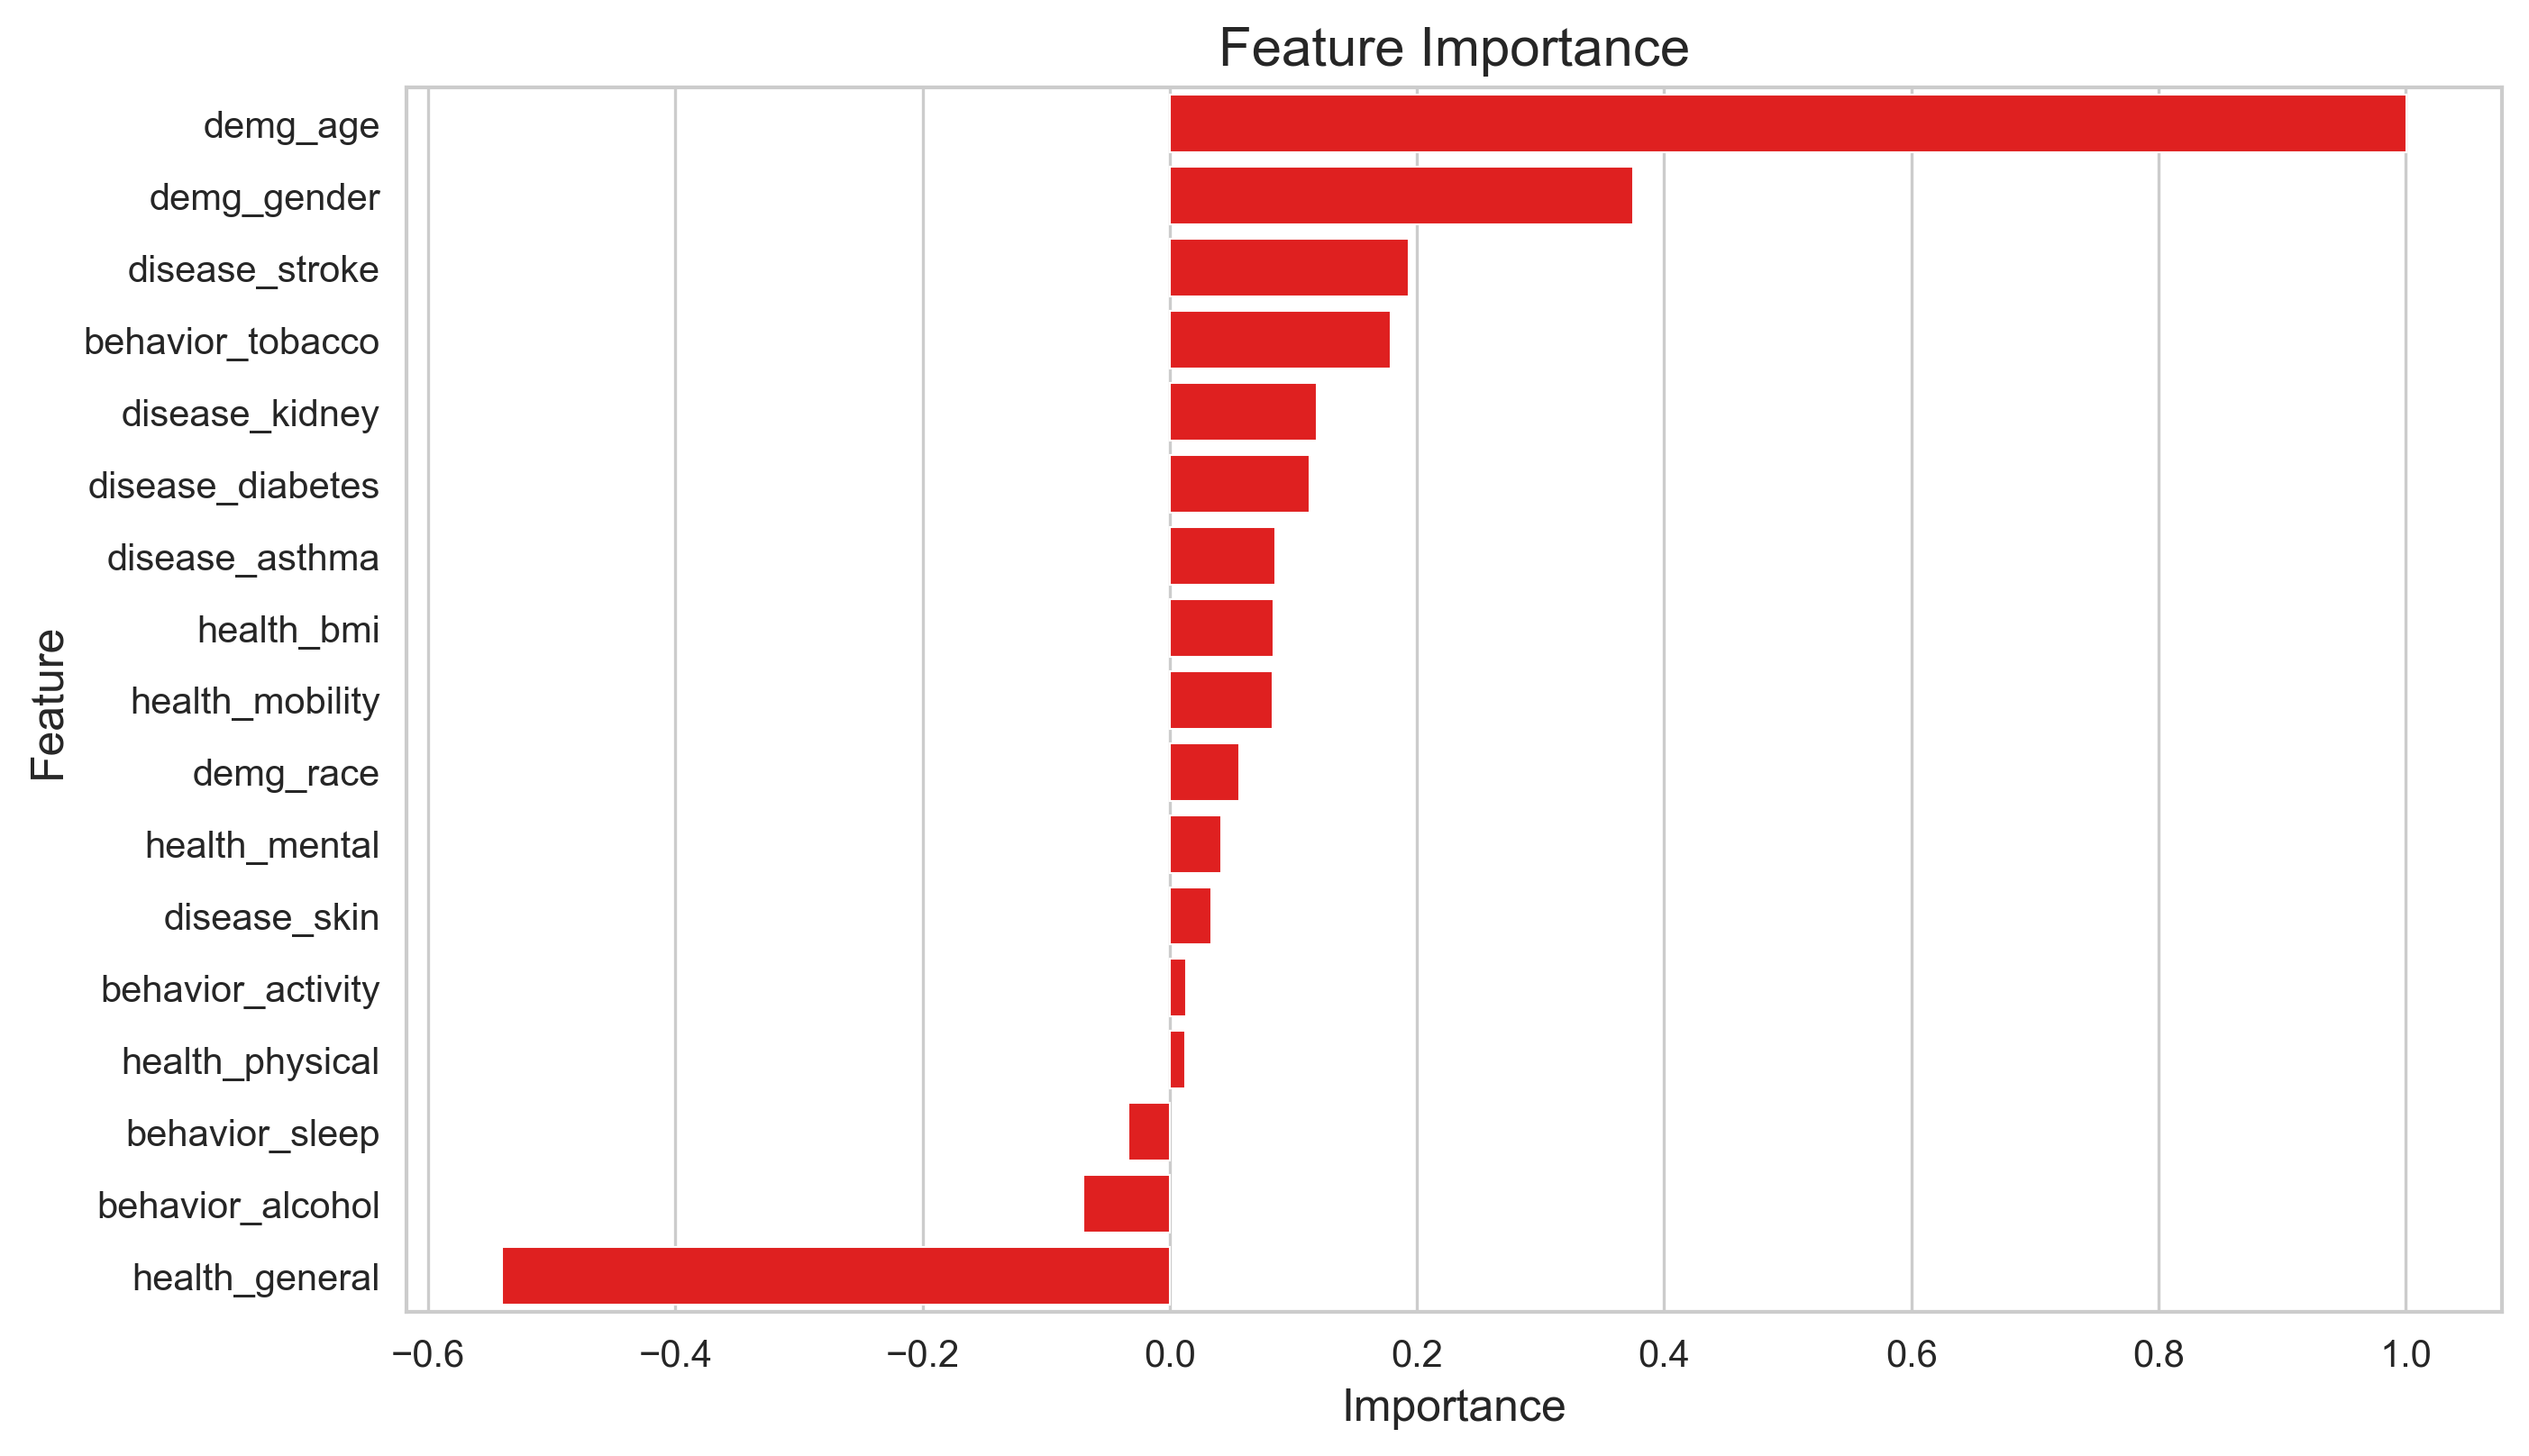

In [331]:
# vizualize feature importance
f, ax = plt.subplots(figsize=(10, 6))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

sns.barplot(x='Importance', y='Feature', data=imp_feat, color='red');
plt.title('Feature Importance')

plt.savefig("feature-importance.jpeg");


In [ ]:
# # option if xgb is the best model
# xgb.plot_importance(gbm)
# xgb.plot_importance(gbm, importance_type='gain')

### 7.2 Interpret<a id='72'></a> 

In [ ]:
# persona 1: couch potato, drinks every day, high BMI, has diabetes

In [ ]:
# persona 2: runner, drinks every day, normal BMI, bordrline diabetes

In [ ]:
# persona 3: walks to works, social drinker, normal BMI, no diabetes

[back to top](#top)